In [66]:
import pickle
import warnings
from math import sqrt

import lightgbm as lgb
import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import pmdarima as pm
import tensorflow as tf
import xgboost as xgb
from bayes_opt import BayesianOptimization
from fbprophet import Prophet
from matplotlib import pyplot as plt
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm

from utils.metrics import evaluate


# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
mpl.rcParams['figure.figsize'] = 18, 8

print(tf.__version__)

netflix_expense = pd.read_csv('dataset/NetflixSpendByYear.csv', parse_dates=['Months in EXPDATE'])
netflix_expense.set_index('Months in EXPDATE', inplace=True)

2.5.0


In [67]:
netflix_expense

,Expense Amount USD,Forecast - Expense Amount USD
Months in EXPDATE,,
2016-01-01,202934.46,
2016-02-01,373884.44999999995,
2016-03-01,1517456.8500000003,
2016-04-01,883318.6900000002,
2016-05-01,712406.12,
...,...,...
2021-11-01,,2700945.1676394176
2021-12-01,,2738807.7311057155
2022-01-01,,2865486.5710113663


In [68]:
netflix_expense = netflix_expense.rename({' Expense Amount USD': 'X', ' Forecast - Expense Amount USD': 'Y'}, axis=1) 

In [74]:
# We split our dataset to be able to evaluate our models


resultsDict = {}
predictionsDict = {}

split_date = '2021-03-01'
split_date2= '2019-10-01'
df_training = netflix_expense.loc[netflix_expense.index < split_date2]
df_test = netflix_expense.loc[netflix_expense.index >= split_date2 ]
df_test = df_test.loc[df_test.index < split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

df_training.to_csv('dataset/training.csv')
df_test.to_csv('dataset/test.csv')

45 days of training data 
 17 days of testing data 


In [107]:
df_test

,X,Y
Months in EXPDATE,,
2019-10-01,4727624.509999995,
2019-11-01,2715303.2199999993,
2019-12-01,3675784.219999999,
2020-01-01,4155166.3399999705,
2020-02-01,3433656.6699999995,
2020-03-01,3518961.149999985,
2020-04-01,3158151.5499999872,
2020-05-01,897909.3900000005,
2020-06-01,1178204.7199999995,


## Simple Exponential Smoothing (SES)

In [76]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.X))):
    temp_train = netflix_expense[:len(df_training)+t]
    model = SimpleExpSmoothing(temp_train.X.astype(float))
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['SES'] = evaluate(df_test.netflix_expense, yhat.values)
predictionsDict['SES'] = yhat.values

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 66.69it/s]

                                     X  Y
Months in EXPDATE                        
2016-01-01                   202934.46   
2016-02-01          373884.44999999995   
2016-03-01          1517456.8500000003   
2016-04-01           883318.6900000002   
2016-05-01                   712406.12   
2016-06-01          1149075.1500000004   
2016-07-01          1151352.2499999998   
2016-08-01           871749.5900000001   
2016-09-01                  2512867.96   
2016-10-01           771520.5499999998   
2016-11-01          2732095.8999999994   
2016-12-01           879712.2100000001   
2017-01-01          1864521.4599999993   
2017-02-01          1168985.5099999998   
2017-03-01          1559815.5000000014   
2017-04-01          1266771.3099999996   
2017-05-01          1727470.4899999993   
2017-06-01          1803320.2099999997   
2017-07-01          1624678.0200000007   
2017-08-01          2076542.0999999996   
2017-09-01          1560040.8000000007   
2017-10-01          1755313.639999

AttributeError: 'DataFrame' object has no attribute 'netflix_expense'

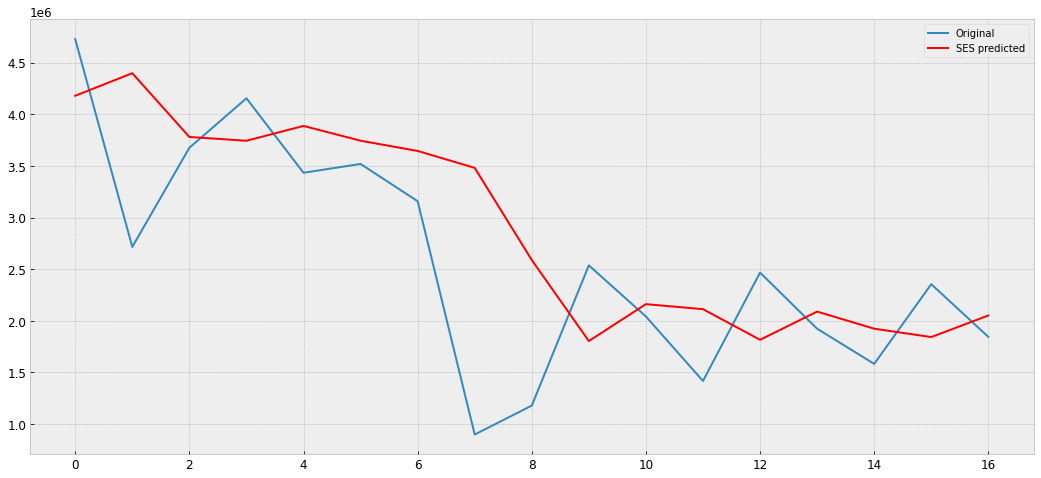

In [77]:
plt.plot(df_test.X.values.astype(float), label='Original')
plt.plot(yhat.values, color='red', label='SES predicted')
plt.legend()

## Holt Winter’s Exponential Smoothing (HWES)

In [43]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.X))):
    temp_train = netflix_expense[:len(df_training)+t]
    model = ExponentialSmoothing(temp_train.X.astype(float))
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['HWES'] = evaluate(df_test.X.astype(float), yhat.values)
predictionsDict['HWES'] = yhat.values

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 152.14it/s]


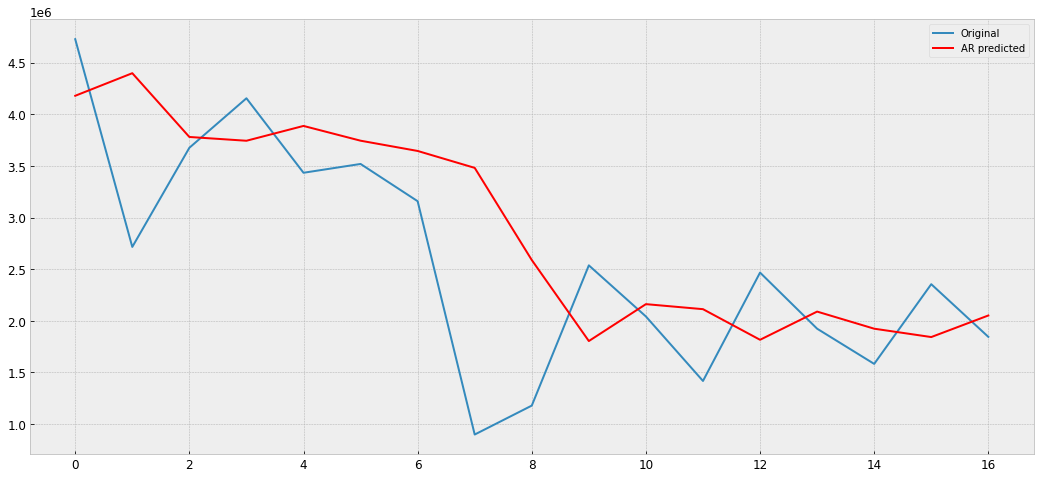

In [44]:
plt.plot(df_test.X.values.astype(float), label='Original')
plt.plot(yhat.values, color='red', label='AR predicted')
plt.legend()

## Autoregression (AR)

In [45]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.X))):
    temp_train = netflix_expense[:len(df_training)+t]
    model = AR(temp_train.X.astype(float))
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AR'] = evaluate(df_test.X.astype(float), yhat.values)
predictionsDict['AR'] = yhat.values

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 258.26it/s]


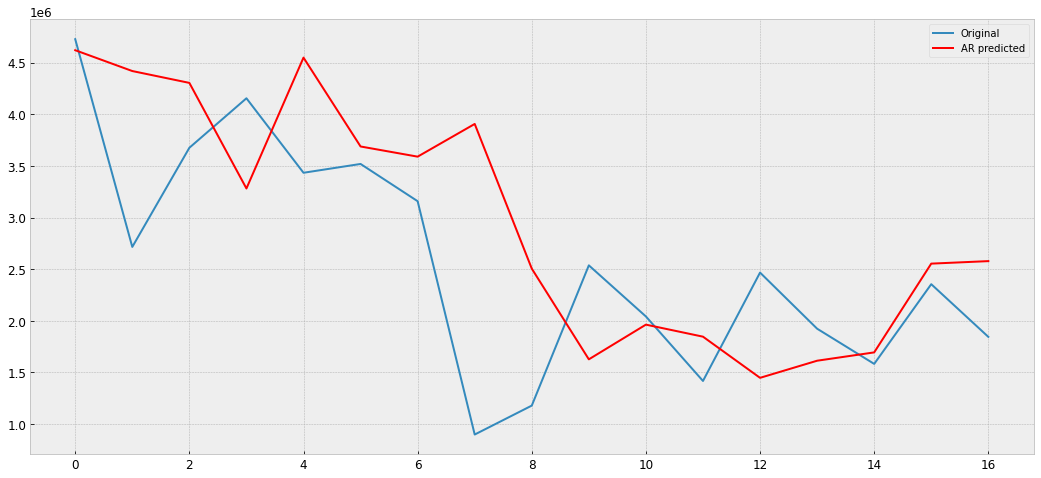

In [47]:
plt.plot(df_test.X.values.astype(float), label='Original')
plt.plot(yhat.values, color='red', label='AR predicted')
plt.legend()

## Moving Average

In [49]:
# MA example

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.X))):
    temp_train = netflix_expense[:len(df_training)+t]
    model = ARMA(temp_train.X.astype(float), order=(0, 1))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['MA'] = evaluate(df_test.X.astype(float), yhat.values)
predictionsDict['MA'] = yhat.values

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 61.89it/s]


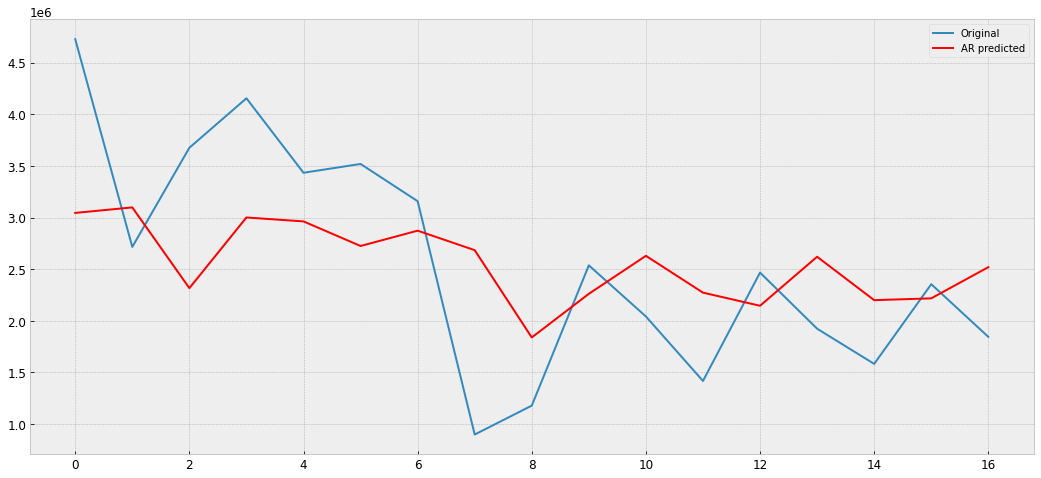

In [50]:
plt.plot(df_test.X.values.astype(float), label='Original')
plt.plot(yhat.values, color='red', label='AR predicted')
plt.legend()

# Autoregressive Moving Average (ARMA)

In [52]:
# ARMA example

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.X))):
    temp_train = netflix_expense[:len(df_training)+t]
    model = ARMA(temp_train.X.astype(float), order=(1, 1))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['ARMA'] = evaluate(df_test.X.astype(float), yhat.values)
predictionsDict['ARMA'] = yhat.values

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 26.63it/s]


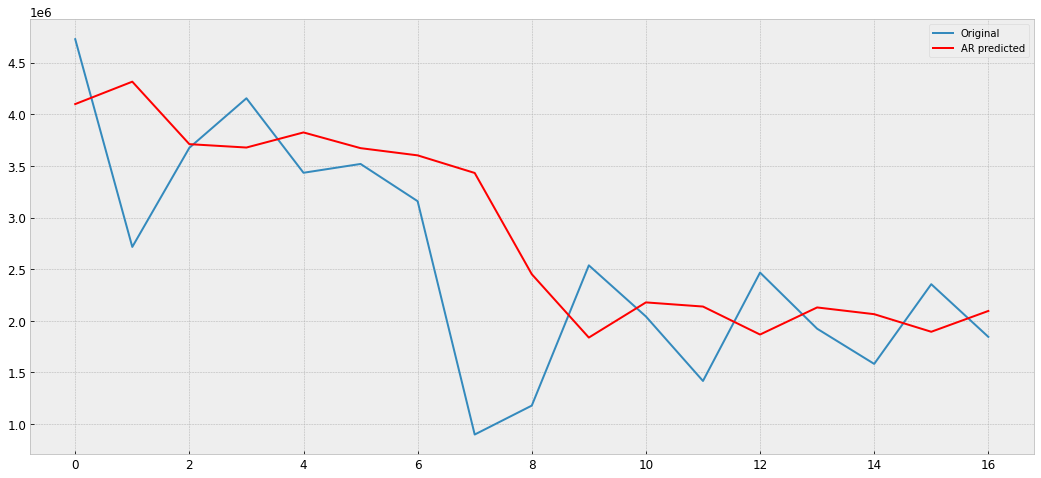

In [53]:
plt.plot(df_test.X.values.astype(float), label='Original')
plt.plot(yhat.values, color='red', label='AR predicted')
plt.legend()

# Autoregressive integrated moving average (ARIMA)

In [108]:
# ARIMA example

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.X))):
    temp_train = netflix_expense[:len(df_training)+t]
    model = ARIMA(temp_train.X.astype(float), order=(1, 0, 0))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['ARIMA'] = evaluate(df_test.X.astype(float), yhat.values)
predictionsDict['ARIMA'] = yhat.values

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 30.11it/s]


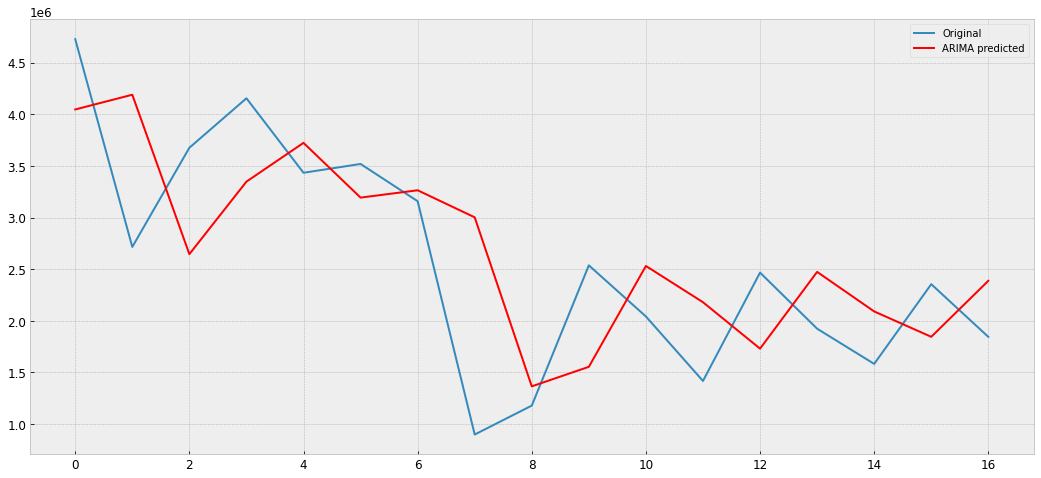

In [109]:
plt.plot(df_test.X.values.astype(float), label='Original')
plt.plot(yhat.values, color='red', label='ARIMA predicted')
plt.legend()

In [56]:
#Auto Arima

autoModel = pm.auto_arima(df_training.X.astype(float), trace=True,
                          error_action='ignore', suppress_warnings=True, seasonal=False)
autoModel.fit(df_training.X.astype(float))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1313.128, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1339.412, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1309.924, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1322.669, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1337.918, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1310.921, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1309.842, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1312.253, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1311.301, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1316.091, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1312.151, Time=0.01 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.234 seconds


ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True)

In [57]:
order = autoModel.order
yhat = list()
for t in tqdm(range(len(df_test.X))):
    temp_train = netflix_expense[:len(df_training)+t]
    model = ARIMA(temp_train.X.astype(float), order=order)
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AutoARIMA {0}'.format(order)] = evaluate(
    df_test.X.astype(float), yhat)
predictionsDict['AutoARIMA {0}'.format(order)] = yhat.values

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 24.75it/s]


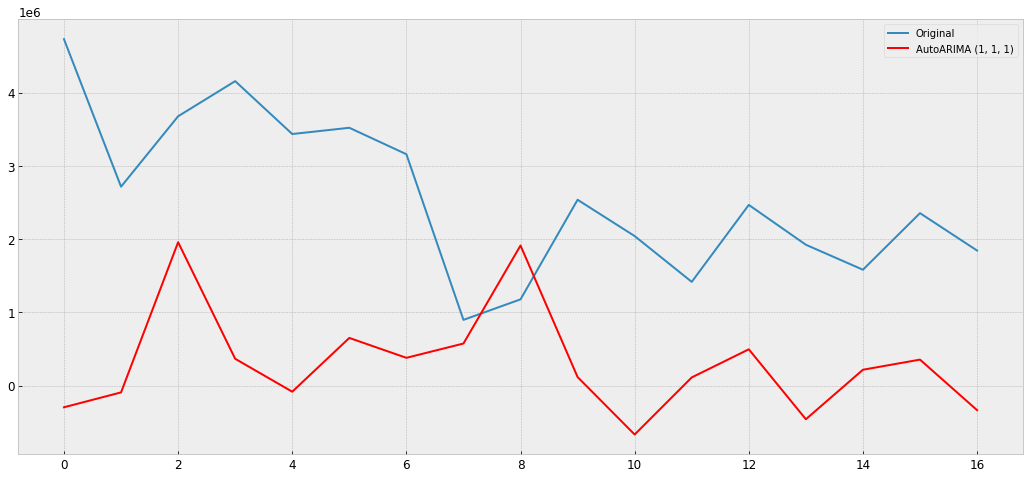

In [58]:
plt.plot(df_test.X.values.astype(float), label='Original')
plt.plot(yhat.values, color='red', label='AutoARIMA {0}'.format(order))
plt.legend()

# SARIMA

In [60]:
# SARIMA example

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.X))):
    temp_train = netflix_expense[:len(df_training)+t]
    model = SARIMAX(temp_train.X.astype(float), order=(
        1, 0, 0), seasonal_order=(0, 0, 0, 3))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['SARIMAX'] = evaluate(df_test.X.astype(float), yhat.values)
predictionsDict['SARIMAX'] = yhat.values

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 57.22it/s]


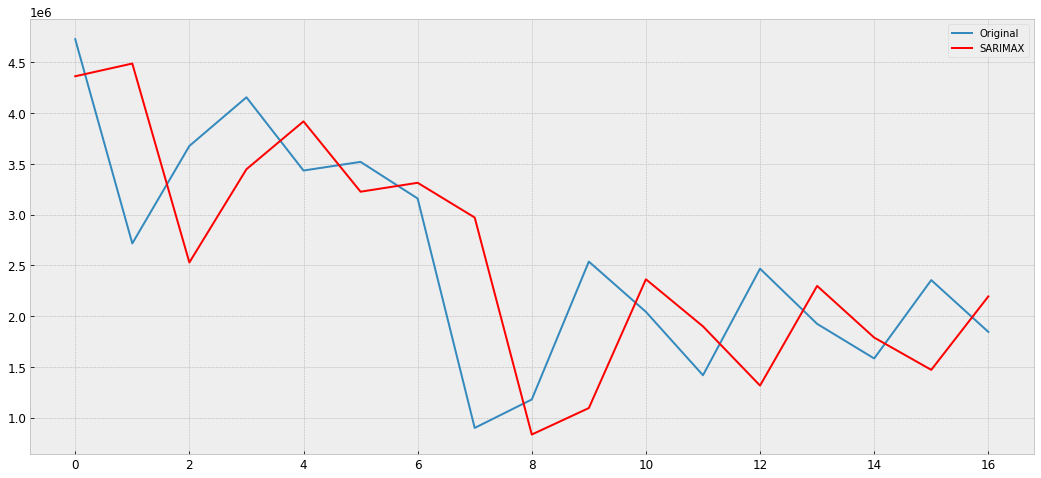

In [61]:
plt.plot(df_test.X.values.astype(float), label='Original')
plt.plot(yhat.values, color='red', label='SARIMAX')
plt.legend()

In [62]:
#AUTO SARIMA

autoModel = pm.auto_arima(df_training.X.astype(float), trace=True, error_action='ignore',
                          suppress_warnings=True, seasonal=True, m=6, stepwise=True)
autoModel.fit(df_training.X.astype(float))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[6] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=1339.412, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=1311.869, Time=0.02 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=1323.498, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=1337.918, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[6] intercept   : AIC=1309.924, Time=0.01 sec
 ARIMA(1,1,0)(0,0,1)[6] intercept   : AIC=1311.848, Time=0.02 sec
 ARIMA(1,1,0)(1,0,1)[6] intercept   : AIC=1313.812, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[6] intercept   : AIC=1310.921, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[6] intercept   : AIC=1309.842, Time=0.02 sec
 ARIMA(1,1,1)(1,0,0)[6] intercept   : AIC=1311.842, Time=0.03 sec
 ARIMA(1,1,1)(0,0,1)[6] intercept   : AIC=1311.773, Time=0.03 sec
 ARIMA(1,1,1)(1,0,1)[6] intercept   : AIC=1313.232, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[6] intercept   : AIC=1322.669, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[6] intercept   : 

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 0, 0, 6),
      suppress_warnings=True)

In [64]:
order = autoModel.order
seasonalOrder = autoModel.seasonal_order
yhat = list()
for t in tqdm(range(len(df_test.X))):
    temp_train = netflix_expense[:len(df_training)+t]
    model = SARIMAX(temp_train.X.astype(float), order=order,
                    seasonal_order=seasonalOrder)
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AutoSARIMAX {0},{1}'.format(order, seasonalOrder)] = evaluate(
    df_test.X.astype(float), yhat.values)
predictionsDict['AutoSARIMAX {0},{1}'.format(
    order, seasonalOrder)] = yhat.values

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 42.79it/s]


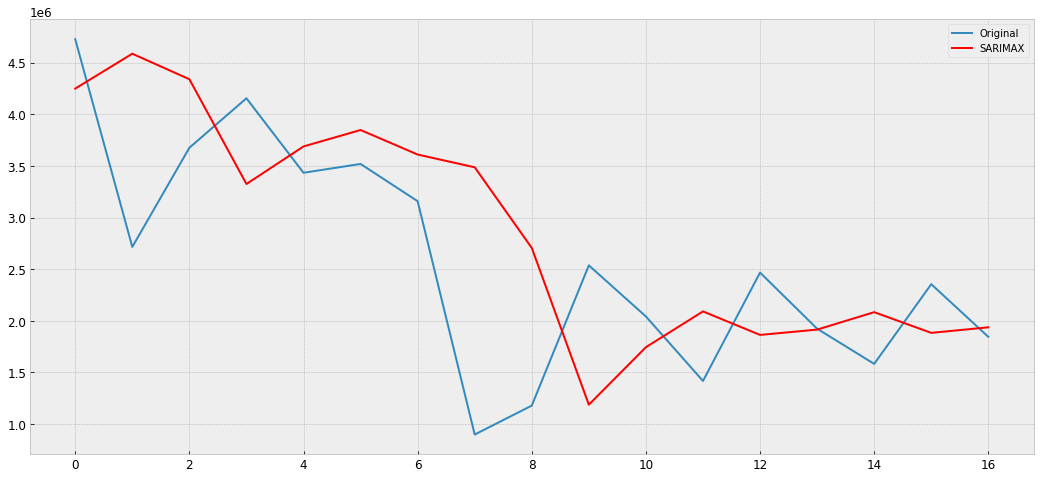

In [65]:
plt.plot(df_test.X.values.astype(float), label='Original')
plt.plot(yhat.values, color='red', label='SARIMAX')
plt.legend()